# Advanced: Gaussian Processes

## Setup

Let's first make sure we have the latest version of PHOEBE 2.4 installed (uncomment this line if running in an online notebook session such as colab).

In [1]:
#!pip install -I "phoebe>=2.4,<2.5"

In [2]:
import phoebe
from phoebe import u # units
import numpy as np
import matplotlib.pyplot as plt

logger = phoebe.logger('error')

## Create fake "observations"

For the purposes of this tutorial, we'll a simplified version of the fake "observations" used in the [Fitting 2 Paper Examples](../examples/0_gendata.ipynb). We'll only use a Johnson:V light curve here and leave the PHOEBE parameters to their true values. We'll also use the spherical distortion method to speed up computations.

For a full analysis of the system, see the stack of examples accompanying the paper.

In [3]:
b = phoebe.default_binary()
b.set_value_all('distortion_method', 'sphere')

b.add_dataset('lc', passband='Johnson:V', dataset='mylcV')

b['sma@binary'] = 9.435
b['requiv@primary'] = 1.473
b['requiv@secondary'] = 0.937
b['incl@binary'] = 87.35
b['period@binary'] = 2.345678901
b['q@binary'] = 0.888
b['teff@primary'] = 6342.
b['teff@secondary'] = 5684.
b['t0@system'] = 1.23456789
b['ecc@orbit'] = 0.148
b['per0@orbit'] = 65.5
b['vgamma@system'] = 185.5

t = np.arange(1., 10.35, 29.44/1440)

b['times@mylcV@dataset'] = t
b.run_compute()

100%|████████████████████████████████████████| 458/458 [00:09<00:00, 47.34it/s]


<ParameterSet: 3 parameters | qualifiers: fluxes, times, comments>

Let's now add some correlated noise to the data, comprised of a Gaussian, exponential and quadratic term. This trend mimics instrumental noise and does not bear any astrophysical significance. It is still important we account for it, as it can affect the values of some astrophysical parameters we do care about (in this case most prominently the parameters most closely related to the depths of the eclipses: the ratio of temperatures and radii).

In [4]:
np.random.seed(1)
noiseV = 0.006 * np.exp( 0.4 + (t-t[0])/(t[-1]-t[0]) ) + np.random.normal(0.0, 0.003, len(t)) - 0.002*(t-t[0])**2/(t[-1]-t[0])**2 + 0.001*(t-t[0])/(t[-1]-t[0]) + 0.0002
noiseV -= np.mean(noiseV)

Let's also generate a noise model that resembles an astrophysical signal: for example, stellar pulsations, which we will represent with a sum of sine functions:

In [5]:
freqs = [1.97, 1.72, 2.98] # oscillation frequencies
amps = [0.034, 0.019, 0.019] # amplitudes
deltas = [0.16, 0.34, 0.86] # phase shifts

terms = [amps[i]*np.sin(2*np.pi*(freqs[i]*t)+deltas[i]) for i in [0,1,2]]
noiseV_puls = np.sum(terms, axis=0) + np.random.normal(0.0, 0.003, len(t))

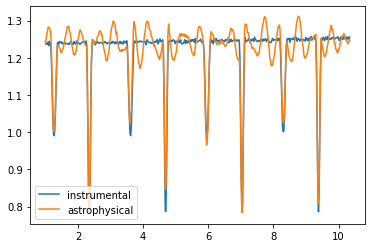

In [6]:
fluxes = b.get_value('fluxes', context='model')
plt.plot(t, fluxes+noiseV, label='instrumental')
plt.plot(t, fluxes+noiseV_puls, label='astrophysical')
plt.legend()

Now we have some fake data with two types of noise suitable for modeling with GPs. 

PHOEBE supports two different GP models: 'sklearn', which uses the GP implementation in [scikit-learn](https://scikit-learn.org/stable/modules/gaussian_process.html), and [celerite2](https://celerite2.readthedocs.io/en/latest/). We have found that sklearn works better for instrumental noise, while celerite2 is designed with astrophysical noise in mind. 

Let's demonstrate how these two work on our case:

## Instrumental noise: the sklearn GPs backend

Let's now add the fluxes with instrumental noise to our bundle and plot the residuals between the true model and the fake observations with added noise:

In [7]:
b['fluxes@mylcV@dataset'] = fluxes + noiseV
b['sigmas@mylcV@dataset'] = 0.003*np.ones_like(fluxes)

/Users/angela/miniconda3/envs/phoebe_2.4/lib/python3.9/site-packages/phoebe/dependencies/autofig/call.py:1305: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  artist = ax.scatter(*datapoint,


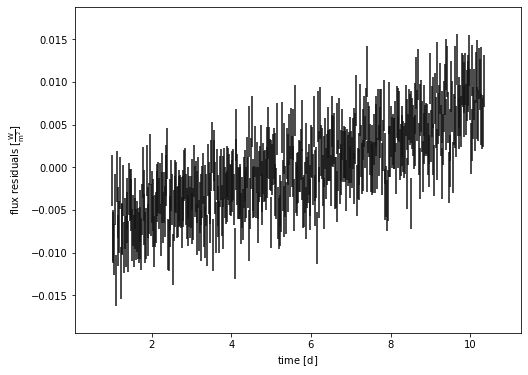

In [8]:
_ = b.plot(y='residuals', show=True)

We can add a gaussian process kernel by only providing the GPs backend we want to use, in this case 'sklearn':

In [9]:
b.add_gaussian_process('sklearn')
print(b['gp_sklearn01'])

ParameterSet: 5 parameters
      kernel@gp_sklearn01@feature: white
   noise_level@gp_sklearn01@fe...: 1.0
   noise_level_bounds@gp_sklea...: fixed
   alg_operation@gp_sklearn01@...: sum
   enabled@gp_sklearn01@phoebe...: True


The default sklearn kernel is 'white', which models, as the name suggests, white noise with a single 'noise_level' parameter. Let's see what the other options are:

In [10]:
b['kernel@gp_sklearn01'].choices

['constant',
 'white',
 'rbf',
 'matern',
 'rational_quadratic',
 'exp_sine_squared',
 'dot_product']

To see in more detail how each one of these works, refer to https://scikit-learn.org/stable/modules/gaussian_process.html#gp-kernels. For this trend, we have found that a sum of a DotProduct and RBF kernel works best (for how we arrived to this see the [Fitting 2 Paper Automated GP Selection Example](../examples/5_gaussian_processes_preparation.ipynb).

Let's switch the kernel type for the current one to DotProduct and add a new RBF kernel. These will then be summed when running compute.

In [11]:
b['kernel@gp_sklearn01'] = 'dot_product'
b.add_gaussian_process('sklearn', kernel='rbf')

# set the parameters of the kernels to ones that model the noise trend closely
b.set_value('sigma_0', feature='gp_sklearn01', value=0.0198)
b.set_value('length_scale', feature='gp_sklearn02', value=71.0)

Sometimes, there may be some residuals in the eclipses due to the PHOEBE model not fitting the data well. GPs are very sensitive to these residuals and more often that not, will begin "stealing" signal from the PHOEBE model, rendering it useless. We can prevent this by masking out the points in the eclipse when running GPs on the residuals, with the parameter 'gp_exclude_phases':

In [12]:
b['gp_exclude_phases@mylcV'] = [[-0.04,0.04], [-0.52,0.40]]

Let's finally compute the model with GPs and plot the result:

100%|████████████████████████████████████████| 458/458 [00:09<00:00, 47.57it/s]
/Users/angela/miniconda3/envs/phoebe_2.4/lib/python3.9/site-packages/phoebe/dependencies/autofig/call.py:1305: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  artist = ax.scatter(*datapoint,
/Users/angela/miniconda3/envs/phoebe_2.4/lib/python3.9/site-packages/phoebe/dependencies/autofig/call.py:1305: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  artist = ax.scatter(*datapoint,


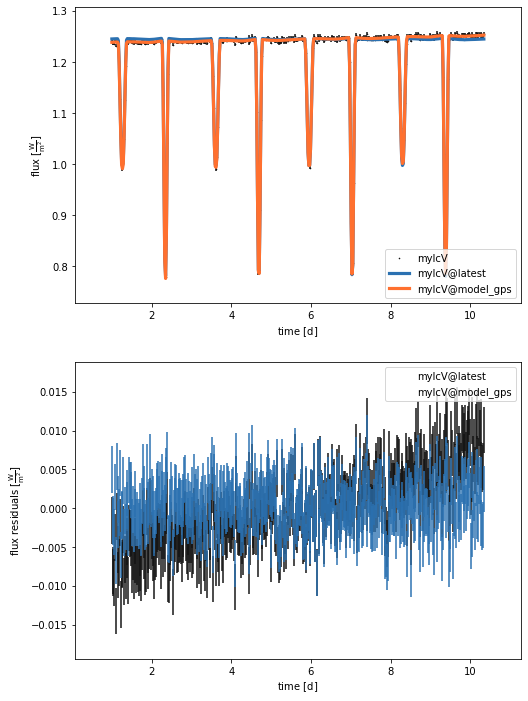

(<autofig.figure.Figure | 2 axes | 5 call(s)>,
 <Figure size 576x864 with 2 Axes>)

In [13]:
b.run_compute(model='model_gps')

b.plot(s={'dataset': 0.005, 'model': 0.02}, ls={'model': '-'},
           marker={'dataset': '.'},
       legend=True)
b.plot(s={'dataset': 0.005, 'model': 0.02}, ls={'model': '-'},
           marker={'dataset': '.'},
       y='residuals',
       legend=True, show=True)

We can see that the GP model accounted for the correlated noise in our data, which in turn allows the PHOEBE model to fit the astrophysical signal more accurately.

## Astrophysical noise: the celerite2 GPs backend

Let's now replace the observed fluxes with those with astrophysical noise and plot the residuals:

In [14]:
b['fluxes@mylcV@dataset'] = fluxes + noiseV_puls
b['sigmas@mylcV@dataset'] = 0.003*np.ones_like(fluxes)

/Users/angela/miniconda3/envs/phoebe_2.4/lib/python3.9/site-packages/phoebe/dependencies/autofig/call.py:1305: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  artist = ax.scatter(*datapoint,


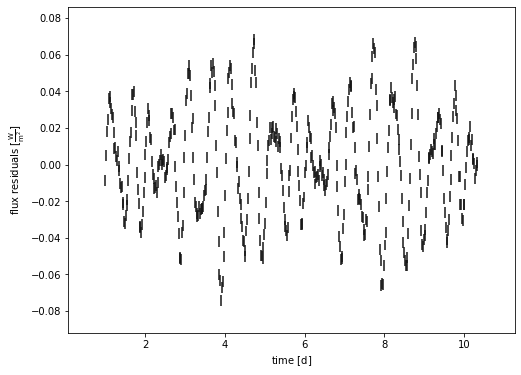

In [15]:
_ = b.plot(model='latest', y='residuals', show=True)

For this type of noise, a gaussian process kernel with the 'celerite2' backend on average works better than the 'sklearn' ExpSineSquared periodic kernel. We'll add two SHO kernels corresponding to the three frequencies used to generate the noise and approximate the other parameters. For a full description of each kernel and its parameters see the [celerite2 documentation](https://celerite2.readthedocs.io/en/latest/api/python/).

In [16]:
b.add_gaussian_process('celerite2', kernel='sho', sigma=0.2, rho=1/1.97, tau=3)
b.add_gaussian_process('celerite2', kernel='sho', sigma=0.2, rho=1/1.72, tau=3)
b.add_gaussian_process('celerite2', kernel='sho', sigma=0.2, rho=1/2.98, tau=3)

<ParameterSet: 11 parameters | contexts: compute, feature>

In [17]:
b.run_compute()

ValueError: failed to pass checks
Run Checks Report: FAIL
ERROR: mixing of GP kernels from sklearn and celerite2 is not supported. Remove or disable kernels from one (5 affected parameters, affecting run_compute)

Uh-oh, we get an error! The issue is that we already have a sklearn kernel attached to our data and ss of yet, PHOEBE only supports one GPs "backend" at a time, either sklearn or celerite2. The two can't be mixed, however you can mix different kernels from the same module. So, let's disable the sklearn GP features before moving on to compute the celerite2 GPs.

In [18]:
b.disable_feature('gp_sklearn01')
b.disable_feature('gp_sklearn02')

<ParameterSet: 4 parameters | qualifiers: alg_operation, length_scale, length_scale_bounds, kernel>

100%|████████████████████████████████████████| 458/458 [00:09<00:00, 47.82it/s]


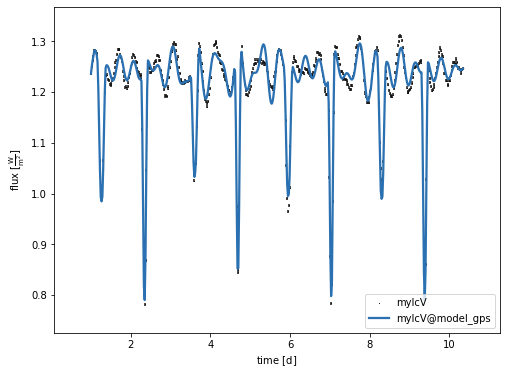

(<autofig.figure.Figure | 1 axes | 2 call(s)>,
 <Figure size 576x432 with 1 Axes>)

In [19]:
b.run_compute(model='model_gps', overwrite=True)

b.plot(s={'dataset': 0.005, 'model': 0.02}, ls={'model': '-'},
           marker={'dataset': '.'},
       legend=True, show=True)

Now we have both a PHOEBE and pulsations model that we can fit jointly! Keep in mind that the GP model is not based on the actual physics of pulsations and can still overfit or steal signal from the PHOEBE model. Therefore, great care needs to be taken in these cases to avoid that!